<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/recommender_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sections as Input

In [1]:
pip install wandb

In [2]:
!!wandb login

['\x1b\x1bwandb\x1b: Currently logged in as: \x1bdoris\x1b (use `wandb login --relogin` to force relogin)']

In [3]:
import wandb

In [4]:
!pip uninstall gensim -y

Found existing installation: gensim 4.1.2
Uninstalling gensim-4.1.2:
  Successfully uninstalled gensim-4.1.2


In [5]:
!pip install gensim

  Using cached gensim-4.1.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (24.1 MB)


In [6]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
from tqdm import tqdm 
from gensim.models.doc2vec import Doc2Vec
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.models import CoherenceModel
from gensim import corpora
from gensim import similarities
import pickle
import os

In [7]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [8]:
print(gensim.__version__)

4.1.2


# Initialization

## Download the Data

### Basic Plus Chords
M7 and 6 reduced to major triad, m7 reduced to m, dominant 7, m7b5, diminished, and all (b5) left as they are.

In [9]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=17djlZRWFSUCviOxRTOF-nwbbZqU5gUP9' -O data.csv

--2021-11-20 18:07:52--  https://docs.google.com/uc?export=download&id=17djlZRWFSUCviOxRTOF-nwbbZqU5gUP9
Resolving docs.google.com (docs.google.com)... 173.194.197.100, 173.194.197.138, 173.194.197.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.197.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/usdk9pconq67u93493u58gqk53k25681/1637431650000/14329102864480165501/*/17djlZRWFSUCviOxRTOF-nwbbZqU5gUP9?e=download [following]
--2021-11-20 18:07:53--  https://doc-0s-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/usdk9pconq67u93493u58gqk53k25681/1637431650000/14329102864480165501/*/17djlZRWFSUCviOxRTOF-nwbbZqU5gUP9?e=download
Resolving doc-0s-4c-docs.googleusercontent.com (doc-0s-4c-docs.googleusercontent.com)... 142.251.6.132, 2607:f8b0:4001:c5a::84
Connecting to doc-0s-4c-docs.googleusercontent.com (doc-0s-4

### Read Chords Input Data

In [10]:
path_to_file = '/content/data.csv'
df = pd.read_csv(path_to_file, sep='\t', index_col="id")
df = df.reset_index()
df.head(5)

,id,file_name,title,tune_mode,tune_id,section_name,section_id,chords
0,0,dataset/jazz1350/26-2.xml,26-2,major,0,A,1,C Eb7 G# B7 E G7 Gm C7 F G#7 C# E7 Am D7 Dm G7
1,1,dataset/jazz1350/26-2.xml,26-2,major,0,A,2,C Eb7 G# B7 E G7 Gm C7 F Eb7 G# B7 E G7 C
2,2,dataset/jazz1350/26-2.xml,26-2,major,0,B,3,Gm C7 Bm E7 A C7 F Bbm Eb7 G# Dm G7
3,3,dataset/jazz1350/26-2.xml,26-2,major,0,A,4,C Eb7 G# B7 E G7 Gm C7 F Eb7 G# B7 E G7 C
4,4,dataset/jazz1350/500 Miles High.xml,500 Miles High,minor,1,NaN,0,Am Am Cm Cm Eb Eb Em7b5 A7 Dm Dm Bm7b5 Bm7b5 B...


### Meta Data

In [11]:
titles = df.loc[:, ['id', 'tune_id', 'section_id', 'section_name', 'title', 'tune_mode']]
titles[:10]

,id,tune_id,section_id,section_name,title,tune_mode
0,0,0,1,A,26-2,major
1,1,0,2,A,26-2,major
2,2,0,3,B,26-2,major
3,3,0,4,A,26-2,major
4,4,1,0,NaN,500 Miles High,minor
5,5,2,0,NaN,502 Blues,minor
6,6,3,1,A,52nd Street Theme,major
7,7,3,2,A,52nd Street Theme,major
8,8,3,3,B,52nd Street Theme,major
9,9,3,4,A,52nd Street Theme,major


In [12]:
titles_dict = titles.to_dict()

sectionid_to_title = titles_dict['title']
sectionid_to_titleid = titles_dict['tune_id']


In [13]:
tunes = df.loc[:, ['tune_id', 'title']].drop_duplicates()
tunes = tunes.set_index('tune_id').to_dict()
titleid_to_title = tunes['title']

In [14]:
titles_rows = titles.to_dict(orient='records')
sectionid_to_section = []
for i, row in enumerate(titles_rows):
  name = f"{row['title']}, section{row['section_id']} ({row['section_name']})"
  sectionid_to_section.append(name)
  

In [15]:
title_to_sectionid = {}

for row in titles.iterrows():
  title = row[1]['title']
  if title not in title_to_sectionid:
    title_to_sectionid[title] = [row[1]['id']]
  else:
    title_to_sectionid[title].append(row[1]['id'])

## Helpers for N-Grams

In [16]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

# Data Preparation

In [17]:
ngrams_for_input = [2]

In [18]:
lines = df.loc[:, 'chords'].tolist()
data = [line.split(' ') for line in lines]

In [19]:
processed_corpus = []
for line in data:
  tune_n = []
  for n in ngrams_for_input:
    tune_n.extend(ngrams(line, n=n))
  processed_corpus.append(tune_n)

for line in processed_corpus[:5]:
  print(line)

['C-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-Gm', 'Gm-C7', 'C7-F', 'F-G#7', 'G#7-C#', 'C#-E7', 'E7-Am', 'Am-D7', 'D7-Dm', 'Dm-G7']
['C-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-Gm', 'Gm-C7', 'C7-F', 'F-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-C']
['Gm-C7', 'C7-Bm', 'Bm-E7', 'E7-A', 'A-C7', 'C7-F', 'F-Bbm', 'Bbm-Eb7', 'Eb7-G#', 'G#-Dm', 'Dm-G7']
['C-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-Gm', 'Gm-C7', 'C7-F', 'F-Eb7', 'Eb7-G#', 'G#-B7', 'B7-E', 'E-G7', 'G7-C']
['Am-Am', 'Am-Cm', 'Cm-Cm', 'Cm-Eb', 'Eb-Eb', 'Eb-Em7b5', 'Em7b5-A7', 'A7-Dm', 'Dm-Dm', 'Dm-Bm7b5', 'Bm7b5-Bm7b5', 'Bm7b5-Bbm', 'Bbm-Bbm', 'Bbm-Fm', 'Fm-Fm', 'Fm-E7', 'E7-E7', 'E7-Fm', 'Fm-Fm', 'Fm-C#', 'C#-C#', 'C#-Fm', 'Fm-Fm', 'Fm-C#', 'C#-C#']


## Initialization for wandb variables

In [20]:
result = {}
result_details = {}

In [21]:
  wandb.init(
      # Set entity to specify your username or team name
      # ex: entity="carey",
      # Set the project where this run will be logged
      project="jazztunes", 
      
      # Track hyperparameters and run metadata
      config={
          "input_data": "https://docs.google.com/uc?export=download&id=17djlZRWFSUCviOxRTOF-nwbbZqU5gUP9",
          "ngrams_input": ngrams_for_input,
      }
  )

wandb: Currently logged in as: doris (use `wandb login --relogin` to force relogin)


In [22]:
artifact = wandb.Artifact('chords', type='dataset')
artifact.add_dir('index/')
wandb.log_artifact(artifact)

wandb: Adding directory to artifact (./index)... Done. 0.2s


In [23]:
model_artifact = wandb.Artifact(
    "trained-model", 
    type="model",
    description="LSI model",
    metadata="")

model_artifact.add_file("/content/index/lsi.model")
wandb.log_artifact(model_artifact)

# TF-IDF

In [24]:
dictionary = corpora.Dictionary(processed_corpus)
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
tfidf = TfidfModel(bow_corpus)

2021-11-20 18:07:59,980 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-20 18:08:00,134 : INFO : built Dictionary(1918 unique tokens: ['Am-D7', 'B7-E', 'C#-E7', 'C-Eb7', 'C7-F']...) from 5403 documents (total 77387 corpus positions)
2021-11-20 18:08:00,138 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(1918 unique tokens: ['Am-D7', 'B7-E', 'C#-E7', 'C-Eb7', 'C7-F']...) from 5403 documents (total 77387 corpus positions)", 'datetime': '2021-11-20T18:08:00.137940', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-11-20 18:08:00,207 : INFO : collecting document frequencies
2021-11-20 18:08:00,214 : INFO : PROGRESS: processing document #0
2021-11-20 18:08:00,245 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 5403 documents and 1918 features (56978 matrix non-zeros)', 'datetime': '2021-11-20T18:08:00.245172'

In [25]:
# dictionary.token2id

In [26]:
!rm -R index
!mkdir index

In [27]:
# Note: SparseMatrixSimilarity crashes due to lacking memory
#from gensim.test.utils import get_tmpfile
#index_tmpfile = get_tmpfile("index")
#index_tfidf = similarities.Similarity('/content/index/index_tfidf', bow_corpus, num_features=len(dictionary))

index_tfidf = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features = len(dictionary))

2021-11-20 18:08:00,525 : INFO : creating sparse index
2021-11-20 18:08:00,529 : INFO : creating sparse matrix from corpus
2021-11-20 18:08:00,534 : INFO : PROGRESS: at document #0
2021-11-20 18:08:01,052 : INFO : created <5403x1918 sparse matrix of type '<class 'numpy.float32'>'
	with 56978 stored elements in Compressed Sparse Row format>


In [28]:
tfidf.save('/content/index/tfidf.model')  # save model
index_tfidf.save('/content/index/tfidf.index') #save index

2021-11-20 18:08:01,065 : INFO : TfidfModel lifecycle event {'fname_or_handle': '/content/index/tfidf.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-20T18:08:01.065615', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-20 18:08:01,080 : INFO : saved /content/index/tfidf.model
2021-11-20 18:08:01,082 : INFO : SparseMatrixSimilarity lifecycle event {'fname_or_handle': '/content/index/tfidf.index', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-20T18:08:01.082735', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-20 18:08:01,086 : INFO : saved /content/index/tfidf.index


## Test for single tunes

In [29]:
def get_sim_scores(tunes, index, model):

    df_sim = pd.DataFrame(columns=['reference_title',
                                  'similar_title',
                                  'ref_section', 
                                  'similar_section', 
                                  'score', 
                                  ])

    for tune in tunes:
      print()
      print("-"*50)
      for s1 in title_to_sectionid[tune]:
      
          query = processed_corpus[s1]
          query_bow = dictionary.doc2bow(query)

          # perform a similarity query against the corpus
          similarities = index[model[query_bow]]
          sims = sorted(enumerate(similarities), key=lambda item: -item[1])
          
          print(s1, sectionid_to_section[s1])
          n = 0
          for s2, s2_score in sims:
            
            # store the top N best results
            if n > 40:
                break
            # don't count self-similarity between sections of the same tune
            if s2 not in title_to_sectionid[tune]:
                n += 1
            
                # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")

                df_sim.loc[len(df_sim)] = [tune,
                                sectionid_to_title[s2],
                                sectionid_to_section[s1], 
                                sectionid_to_section[s2], 
                                s2_score, 
                                ]
    return df_sim

In [30]:
tunes_eval_list = [
  "Sweet Sue, Just You",
  "These Foolish Things", 
  "Blue Moon",
  "All Of Me",
  "All God's Chillun Got Rhythm",
  "I Got Rhythm",
  "Bye Bye Blackbird",
  "Old Fashioned Love",
  "Dinah",
  "Honeysuckle Rose",
  "Misty",
  "We'll Be Together Again",
  "East Of The Sun",
  "Sophisticated Lady",
  "Perdido",
]

In [31]:
%%time
df_sim = get_sim_scores(tunes_eval_list, index_tfidf, tfidf)
df_tfidf = df_sim[:]


--------------------------------------------------
3752 Sweet Sue, Just You, section1 (A)
3753 Sweet Sue, Just You, section2 (A)
3754 Sweet Sue, Just You, section3 (B)
3755 Sweet Sue, Just You, section4 (A)

--------------------------------------------------
3866 These Foolish Things, section1 (A)
3867 These Foolish Things, section2 (A)
3868 These Foolish Things, section3 (B)
3869 These Foolish Things, section4 (A)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

-----------

In [32]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50)
fig.show()

In [33]:
def recommend_tune(df, tune_name):

  df_tune = df.query(f'reference_title == "{tune_name}"')
  ff = df_tune.iloc[:]

  # get the maximum similarity score for each section and store in new column
  ff['max'] = ff.groupby('ref_section')['score'].transform('max')

  # scale the score with the maxmum value of each section
  ff['score_div_max'] = ff['score'] / ff['max']

  # consider only the top N tunes for each group
  ff = ff.sort_values(['ref_section', 'score_div_max'], ascending=[True, False])
  result = ff.groupby('ref_section').head(30)
  
  # if multiple rows from the same similar tune, keep only the similar_title with the highest score_div_max
  result = result.groupby('similar_title').max('score_div_max').sort_values('score_div_max', ascending=False)
  
  # add the name of the reference tune
  result['reference'] = tune_name
  result = result.reset_index()
  result = result.loc[:, ['reference', 'similar_title', 'score', 'max', 'score_div_max']]
  return result, ff

In [34]:
result['tfidf'], result_details['tfidf'] = recommend_tune(df_sim, "These Foolish Things")
result['tfidf'].head(30)

2021-11-20 18:08:13,404 : INFO : NumExpr defaulting to 2 threads.


,reference,similar_title,score,max,score_div_max
0,These Foolish Things,Too Young To Go Steady,0.700287,0.700287,1.000000
1,These Foolish Things,Mountain Greenery,0.767828,0.767828,1.000000
2,These Foolish Things,More Than You Know,0.683313,0.683313,1.000000
3,These Foolish Things,"Way You Look Tonight, The",0.730743,0.767828,0.982762
4,These Foolish Things,This Is All I Ask,0.655513,0.700287,0.936063
5,These Foolish Things,Emily,0.692265,0.767828,0.931013
6,These Foolish Things,I Like The Likes Of You,0.690350,0.767828,0.899094
7,These Foolish Things,Jeepers Creepers,0.666954,0.767828,0.891968
8,These Foolish Things,I Won't Dance,0.655769,0.767828,0.881929
9,These Foolish Things,Long Ago And Far Away,0.648045,0.767828,0.871296


In [35]:
columns = ["Reference", "Recommendation", "Score", "Score_Div_Max"]
table = wandb.Table(columns=columns)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)

  for index, row in result.iterrows():
    table.add_data(tune, row['similar_title'], row['score'], row['score_div_max'])

wandb.log({"tfidf": table})


# LSA (Latent Semantic Analysis), aka LSI (Latent Semantic Index) 

In [36]:
from collections import defaultdict

In [37]:
num_topics = 100

# remove words that appear only once
frequency = defaultdict(int)
for text in processed_corpus:
    for token in text:
        frequency[token] += 1

data = [[token for token in text if frequency[token] > 1] for text in processed_corpus]
dictionary = corpora.Dictionary(data)

# doc2bow counts the number of occurences of each distinct word,
# converts the word to its integer word id and returns the result
# as a sparse vector

bow_corpus = [dictionary.doc2bow(text) for text in data]
lsi = LsiModel(bow_corpus, id2word=dictionary, num_topics=num_topics)  # num_topics can be maximum the size of the number of unique tokens

2021-11-20 18:08:14,322 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-11-20 18:08:14,476 : INFO : built Dictionary(1466 unique tokens: ['Am-D7', 'B7-E', 'C#-E7', 'C-Eb7', 'C7-F']...) from 5403 documents (total 76935 corpus positions)
2021-11-20 18:08:14,482 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(1466 unique tokens: ['Am-D7', 'B7-E', 'C#-E7', 'C-Eb7', 'C7-F']...) from 5403 documents (total 76935 corpus positions)", 'datetime': '2021-11-20T18:08:14.482297', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-11-20 18:08:14,557 : INFO : using serial LSI version on this node
2021-11-20 18:08:14,559 : INFO : updating model with new documents
2021-11-20 18:08:14,562 : INFO : preparing a new chunk of documents
2021-11-20 18:08:14,599 : INFO : using 100 extra samples and 2 power iterations
2021-11-20 18:08:14,603 : INFO : 1st phas

In [38]:
#index_lsi = similarities.Similarity('/content/index/index_lsi', bow_corpus, num_features=len(dictionary))

In [39]:
index_lsi = similarities.SparseMatrixSimilarity(lsi[bow_corpus], num_features = len(dictionary))
#index_lsi = similarities.MatrixSimilarity(lsi[bow_corpus])  # transform corpus to LSI space and index it


2021-11-20 18:08:15,240 : INFO : creating sparse index
2021-11-20 18:08:15,252 : INFO : creating sparse matrix from corpus
2021-11-20 18:08:15,266 : INFO : PROGRESS: at document #0
2021-11-20 18:08:16,440 : INFO : created <5403x1466 sparse matrix of type '<class 'numpy.float32'>'
	with 540299 stored elements in Compressed Sparse Row format>


In [40]:
lsi.save('/content/index/lsi.model')
index_lsi.save('/content/index/lsi_matrixsim.index')


2021-11-20 18:08:16,456 : INFO : Projection lifecycle event {'fname_or_handle': '/content/index/lsi.model.projection', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-11-20T18:08:16.456478', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-20 18:08:16,461 : INFO : saved /content/index/lsi.model.projection
2021-11-20 18:08:16,463 : INFO : LsiModel lifecycle event {'fname_or_handle': '/content/index/lsi.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': ['projection', 'dispatcher'], 'datetime': '2021-11-20T18:08:16.463230', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-11-20 18:08:16,466 : INFO : not storing attribute projection
2021-11-20 18:08:16,468 : INFO : not storing attribute dispatch

In [41]:
!ls -la /content/index

total 5964
drwxr-xr-x 2 root root    4096 Nov 20 18:08 .
drwxr-xr-x 1 root root    4096 Nov 20 18:08 ..
-rw-r--r-- 1 root root 4344909 Nov 20 18:08 lsi_matrixsim.index
-rw-r--r-- 1 root root   44030 Nov 20 18:08 lsi.model
-rw-r--r-- 1 root root 1174291 Nov 20 18:08 lsi.model.projection
-rw-r--r-- 1 root root  478329 Nov 20 18:08 tfidf.index
-rw-r--r-- 1 root root   52277 Nov 20 18:08 tfidf.model


### Test for single tunes

In [42]:
%%time
df_sim = get_sim_scores(tunes_eval_list, index=index_lsi, model=lsi)
df_lsi = df_sim[:]


--------------------------------------------------
3752 Sweet Sue, Just You, section1 (A)
3753 Sweet Sue, Just You, section2 (A)
3754 Sweet Sue, Just You, section3 (B)
3755 Sweet Sue, Just You, section4 (A)

--------------------------------------------------
3866 These Foolish Things, section1 (A)
3867 These Foolish Things, section2 (A)
3868 These Foolish Things, section3 (B)
3869 These Foolish Things, section4 (A)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

-----------

In [43]:
import plotly.express as px
fig = px.histogram(df_sim, x="score", nbins=50)
fig.show()

In [44]:
result, details = recommend_tune(df_sim, 'These Foolish Things')
result.head(30)

,reference,similar_title,score,max,score_div_max
0,These Foolish Things,"Way You Look Tonight, The",0.899070,0.899070,1.000000
1,These Foolish Things,Isn't It A Pity,0.914370,0.914370,1.000000
2,These Foolish Things,Mountain Greenery,0.868352,0.899070,1.000000
3,These Foolish Things,I Like The Likes Of You,0.884461,0.899070,0.983751
4,These Foolish Things,I Won't Dance,0.873319,0.899070,0.982228
5,These Foolish Things,"Party's Over, The",0.880144,0.899070,0.978949
6,These Foolish Things,Heart And Soul,0.873083,0.899070,0.975594
7,These Foolish Things,Let's Fall In Love,0.866993,0.899070,0.965477
8,These Foolish Things,Jeepers Creepers,0.863707,0.899070,0.960666
9,These Foolish Things,I'm Old Fashioned,0.855656,0.899070,0.960484


In [45]:
columns = ["Reference", "Recommendation", "Score", "Score_Div_Max"]
table = wandb.Table(columns=columns)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)

  for index, row in result.iterrows():
    table.add_data(tune, row['similar_title'], row['score'], row['score_div_max'])

wandb.log({"lsi": table})

## Determine Number of Topics for LSI Model

This sample comes from Datacamp: 

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python


What is the best way to determine k (number of topics) in topic modeling? Identify the optimum number of topics in the given corpus text is a challenging task. We can use the following options for determining the optimum number of topics:

* One way to determine the optimum number of topics is to consider each topic as a cluster and find out the effectiveness of a cluster using the Silhouette coefficient.
* Topic coherence measure is a realistic measure for identifying the number of topics.

Topic Coherence measure is a widely used metric to evaluate topic models. It uses the latent variable models. Each generated topic has a list of words. In topic coherence measure, you will find average/median of pairwise word similarity scores of the words in a topic. The high value of topic coherence score model will be considered as a good topic model. 

In [46]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary, doc_term_matrix

In [47]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [48]:
def plot_graph(doc_clean,start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [49]:
# evaluate a good number of topics for the LSI Model. This takes some time.

if False:

  start, stop, step = 1, 500, 10
  plot_graph(data, start, stop, step)

For unigrams, the best number of topics seems to be around 20.

For unigrams plus bigrams, the coherence score drops down until 100 and then continuously rises until 500 and continues to rise. Same for bigrams-only.

# Doc2Vec

In [50]:
def get_tagged_documents(corpus):
  for i, tokens in enumerate(corpus):
    yield gensim.models.doc2vec.TaggedDocument(tokens, [i, f'titleid_{sectionid_to_titleid[i]}'])
    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])  # diatonic chord distance is a bit better

In [51]:
train_corpus = list(get_tagged_documents(processed_corpus))
train_corpus[1000]

TaggedDocument(words=['C-Am', 'Am-Dm', 'Dm-G7', 'G7-Em', 'Em-Am', 'Am-Dm', 'Dm-G7', 'G7-Gm', 'Gm-C7', 'C7-F', 'F-Bb7', 'Bb7-Am', 'Am-D7', 'D7-Dm', 'Dm-G7'], tags=[500, 'titleid_160'])

In [52]:
import multiprocessing

common_kwargs = dict(
    epochs=40, 
    min_count=1,
    workers=multiprocessing.cpu_count(), 
    negative=10, 
)

print(f"CPU Count: {multiprocessing.cpu_count()}")

dm = 0 # PV-DBOW
dm = 1 # PV-DM
sample = 0.001  # huge influence; 0.001 is best for a high value in the similarity of diatonic chords of the Cmaj scale
window = 2  # 2 is best for diatonic chords
negative = 10 # 10 is best for diatonic chords

model = Doc2Vec(train_corpus,
                dm=1, 
                vector_size=100, 
                window=window, 
                epochs=40,
                workers=1,
                min_count=1,
                negative=negative,
                sample=sample,
                seed=42,
                )

2021-11-20 18:08:29,421 : INFO : collecting all words and their counts
2021-11-20 18:08:29,422 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-11-20 18:08:29,464 : INFO : PROGRESS: at example #10000, processed 139208 words (3514834/s), 1897 word types, 1619 tags
2021-11-20 18:08:29,485 : INFO : collected 1918 word types and 7215 unique tags from a corpus of 10806 examples and 154774 words
2021-11-20 18:08:29,487 : INFO : Creating a fresh vocabulary
2021-11-20 18:08:29,500 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 1918 unique words (100.0%% of original 1918, drops 0)', 'datetime': '2021-11-20T18:08:29.500012', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-11-20 18:08:29,506 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 154774 word corpus (100.0%% of original 154774,

CPU Count: 2


2021-11-20 18:08:30,357 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-20 18:08:30,359 : INFO : EPOCH - 1 : training on 154774 raw words (107943 effective words) took 0.8s, 139265 effective words/s
2021-11-20 18:08:31,114 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-20 18:08:31,116 : INFO : EPOCH - 2 : training on 154774 raw words (107997 effective words) took 0.7s, 144843 effective words/s
2021-11-20 18:08:31,860 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-20 18:08:31,864 : INFO : EPOCH - 3 : training on 154774 raw words (107915 effective words) took 0.7s, 146382 effective words/s
2021-11-20 18:08:32,648 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-20 18:08:32,650 : INFO : EPOCH - 4 : training on 154774 raw words (108272 effective words) took 0.8s, 139401 effective words/s
2021-11-20 18:08:33,407 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-

### Test the distance between C and the diatonic chords

Test if the model can capture that the diatonic chords are closer to the root.

Do this only if the input corpus contains the unigrams. 

In [53]:
test_tokens = ['C',
              'Dm',
              'Em',
              'F',
              'G7',
              'Am',
              'Bm7b5',
              'F7',
              'D7',
              'A7',
              'E7',
              'B7',
              'F#7',
               'Cm',
               'D']

if 1 in ngrams_for_input:
  ref = 'C'
  for t in test_tokens:
    print(f"{model.wv.similarity(ref, t):.3f}: {ref} <-> {t}")

In [54]:
if 1 in ngrams_for_input:
  model.wv.similar_by_word('C', topn=20)

Plot the generated word vectors in 2D space

In [55]:
from sklearn.manifold import TSNE

# input data: vectors for all tokens
weights = model.wv.vectors

# only do this when the vocabulary is not too big....
if len(weights) < 100:

  # do T-SNE
  tsne = TSNE(n_components=2, 
              random_state=42,
              perplexity=30,
              learning_rate='auto',
              init='pca',
              n_iter=2000
              )
  T = tsne.fit_transform(weights)

  # plot
  projected = pd.DataFrame(T)

  fig = px.scatter(
      projected, 
      x=0, y=1,
      #color='mode',
      text=model.wv.index_to_key,
      width=800, height=600,
      title="T-SNE applied to Chord Vectors for Tunes in Cmaj/Amin"
  )
  fig.update_traces(textposition='top center')
  fig.update_traces(textfont_size=12, selector=dict(type='scatter'))
  fig.show()

### Test for single tunes

In [56]:
len(sectionid_to_section)

5403

In [57]:
len(model.dv)

7215

In [58]:
title_to_sectionid['These Foolish Things']

[3866, 3867, 3868, 3869]

In [59]:
section_key = 3868

In [60]:
model.dv.similar_by_key(section_key, topn=20)

[(43, 0.6782081723213196),
 (84, 0.6491435766220093),
 (45, 0.641556978225708),
 (3875, 0.6325454711914062),
 ('titleid_998', 0.5843778848648071),
 (1064, 0.5704977512359619),
 (2222, 0.569108784198761),
 (2347, 0.5604077577590942),
 (176, 0.5595685839653015),
 (512, 0.5560452342033386),
 (210, 0.5549530982971191),
 (5205, 0.5545634031295776),
 ('titleid_1448', 0.5518192648887634),
 (1579, 0.5422195196151733),
 (3694, 0.5413293838500977),
 (1889, 0.5366091132164001),
 ('titleid_13', 0.5322017073631287),
 (2603, 0.5283887982368469),
 (2967, 0.5152822732925415),
 (2600, 0.510577380657196)]

In [61]:
sectionid_to_section[1889]

"I've Told Eve'ry Little Star, section3 (B)"

In [62]:
titles.query('title == "These Foolish Things"')

,id,tune_id,section_id,section_name,title,tune_mode
3866,3866,1170,1,A,These Foolish Things,major
3867,3867,1170,2,A,These Foolish Things,major
3868,3868,1170,3,B,These Foolish Things,major
3869,3869,1170,4,A,These Foolish Things,major


In [63]:
tune_key = 'titleid_1170'

In [64]:
model.dv.similar_by_key(tune_key, topn=20)

[(3867, 0.8789698481559753),
 (3869, 0.8227396607398987),
 (3866, 0.8081152439117432),
 (1067, 0.6633501052856445),
 ('titleid_457', 0.6557653546333313),
 (4828, 0.6425423622131348),
 (3224, 0.6391641497612),
 (2341, 0.5959892868995667),
 (1688, 0.5954562425613403),
 (4025, 0.5945120453834534),
 (2774, 0.5896062254905701),
 (1171, 0.5866377949714661),
 (1068, 0.5787327289581299),
 ('titleid_974', 0.5777230262756348),
 (2967, 0.5767199397087097),
 (4027, 0.5741989612579346),
 (1066, 0.5724884271621704),
 (2086, 0.5693561434745789),
 (3381, 0.5653538107872009),
 (1088, 0.5653234124183655)]

In [65]:
titles.iloc[755]

id                                           755
tune_id                                      234
section_id                                     5
section_name                                   D
title           Chega De Saudade (No More Blues)
tune_mode                                  minor
Name: 755, dtype: object

#### Section Similarity


In [66]:
def get_section_scores_doc2vec(tunes):

    df_sim = pd.DataFrame(columns=['reference_title',
                                  'similar_title',
                                  'ref_section', 
                                  'similar_section', 
                                  'score', 
                                  ])

    for tune in tunes:
      print()
      print("-"*50)
      for s1 in title_to_sectionid[tune]:
      
          # sections are tagged with the numeric sectionid and can be used for querying
          sims = model.dv.similar_by_key(s1, topn=40)
          
          print(s1, sectionid_to_section[s1])
          n = 0
          for s2, s2_score in sims:
              if type(s2) == int:  # only consider similarities to sectionids; tuneids are strings
                  # don't count self-similarity between sections of the same tune
                  if s2 not in title_to_sectionid[tune]:
                      n += 1
                  
                      # print(f"\t{s2_score:.3f} {sectionid_to_section[s2]}")

                      df_sim.loc[len(df_sim)] = [tune,
                                      sectionid_to_title[s2],
                                      sectionid_to_section[s1], 
                                      sectionid_to_section[s2], 
                                      s2_score, 
                                      ]
    return df_sim

In [67]:
df_section_sim = get_section_scores_doc2vec(tunes_eval_list)
df_word2vec = df_section_sim[:]


--------------------------------------------------
3752 Sweet Sue, Just You, section1 (A)
3753 Sweet Sue, Just You, section2 (A)
3754 Sweet Sue, Just You, section3 (B)
3755 Sweet Sue, Just You, section4 (A)

--------------------------------------------------
3866 These Foolish Things, section1 (A)
3867 These Foolish Things, section2 (A)
3868 These Foolish Things, section3 (B)
3869 These Foolish Things, section4 (A)

--------------------------------------------------
496 Blue Moon, section1 (A)
497 Blue Moon, section2 (A)
498 Blue Moon, section3 (B)
499 Blue Moon, section4 (A)

--------------------------------------------------
198 All Of Me, section1 (A)
199 All Of Me, section2 (B)
200 All Of Me, section3 (A)
201 All Of Me, section4 (C)

--------------------------------------------------
188 All God's Chillun Got Rhythm, section1 (A)
189 All God's Chillun Got Rhythm, section2 (B)
190 All God's Chillun Got Rhythm, section3 (A)
191 All God's Chillun Got Rhythm, section4 (C)

-----------

In [68]:
import plotly.express as px
fig = px.histogram(df_section_sim, x="score", nbins=50, title='Scores for Section Similarities')
fig.show()

In [69]:
result, details = recommend_tune(df_section_sim, 'Perdido')
result.head(50)

,reference,similar_title,score,max,score_div_max
0,Perdido,I Get A Kick Out Of You,0.963911,0.963911,1.000000
1,Perdido,"Theme, The",0.977783,0.977783,1.000000
2,Perdido,I Got Rhythm,0.977566,0.977783,0.999777
3,Perdido,Two Not One,0.976435,0.977783,0.998621
4,Perdido,Scrapple From The Apple,0.973295,0.977783,0.995409
5,Perdido,Oleo,0.972060,0.977783,0.994147
6,Perdido,Dexterity,0.970435,0.977783,0.992484
7,Perdido,Moose The Mooche,0.969845,0.977783,0.991881
8,Perdido,Salt Peanuts,0.968805,0.977783,0.990818
9,Perdido,Thriving From A Riff,0.967987,0.977783,0.989981


In [70]:
columns = ["Reference", "Recommendation", "Score", "Score_Div_Max"]
table = wandb.Table(columns=columns)

for tune in tunes_eval_list:
  result, details = recommend_tune(df_sim, tune)

  for index, row in result.iterrows():
    table.add_data(tune, row['similar_title'], row['score'], row['score_div_max'])

wandb.log({"doc2vec": table})



#### Document Similarity


The TitleId is tagged with the prefix `title_id`, so that it can be distinguished from the sectionid tags, which are numeric.

In [71]:
tunes_eval_list

['Sweet Sue, Just You',
 'These Foolish Things',
 'Blue Moon',
 'All Of Me',
 "All God's Chillun Got Rhythm",
 'I Got Rhythm',
 'Bye Bye Blackbird',
 'Old Fashioned Love',
 'Dinah',
 'Honeysuckle Rose',
 'Misty',
 "We'll Be Together Again",
 'East Of The Sun',
 'Sophisticated Lady',
 'Perdido']

In [72]:
# convert titles to titleid; if multiple tunes with same title, takes the first one. 
titleid_eval = []
for title in tunes_eval_list:
  titleid_eval.append(titles.query(f'title == "{title}"').reset_index().loc[0,'tune_id'])
titleid_eval

[1138, 1170, 159, 60, 57, 505, 206, 1642, 308, 472, 807, 1259, 341, 1082, 951]

In [73]:
for titleid in titleid_eval:
  print()
  print(titleid_to_title[titleid])
  sims = model.dv.similar_by_key(f'titleid_{titleid}', topn=30)
  for key, value in sims:
    if type(key) == str:  # only display document similarities, skip all section similarities
      print(f"{value:.3f} {titleid_to_title[int(key.replace('titleid_', ''))]}")



Sweet Sue, Just You
0.792 My Secret Love
0.787 Sweet Sue

These Foolish Things
0.656 Heart And Soul
0.578 Put On A Happy Face
0.564 Rosetta
0.562 New Orleans
0.557 Breezin' Along With The Breeze
0.554 Charleston, The
0.553 Wouldn't It Be Loverly
0.553 Don't Be That Way
0.553 Mountain Greenery

Blue Moon
0.670 52nd Street Theme

All Of Me
0.618 I'm Through With Love
0.617 Blue (And Broken Hearted)
0.613 Into Each Life Some Rain Must Fall
0.578 Martha (Maizie)
0.573 Petit Fleur
0.564 My Baby Just Cares For Me
0.554 Everywhere You Go, Sunshine Follows You
0.544 Spain

All God's Chillun Got Rhythm
0.577 Teach Me Tonight
0.558 Bossa Antigua
0.558 Too Young To Go Steady
0.551 Diane
0.547 Things We Did Last Summer, The
0.546 At Last

I Got Rhythm
0.932 I Got Rhythm
0.632 Cottontail
0.608 Webb City
0.590 Let's Fall In Love
0.589 Lennie-Bird
0.578 Forever Sonny

Bye Bye Blackbird
0.712 It's Been A Long Long Time
0.665 Moten Swing
0.658 Frenesi

Old Fashioned Love
0.636 Girl Of My Dreams
0.631 

In [74]:
wandb.finish()

wandb: ERROR Control-C detected -- Run data was not synced


Venn diagrams for Results

In [98]:
tune = "We'll Be Together Again"

df, details = recommend_tune(df_tfidf, tune)
tfidf_tunes = list(df.head(30).loc[:,'similar_title'])

df, details = recommend_tune(df_lsi, tune)
lsi_tunes = list(df.head(30).loc[:,'similar_title'])

df, details = recommend_tune(df_word2vec, tune)
word2vec_tunes = list(df.head(30).loc[:,'similar_title'])

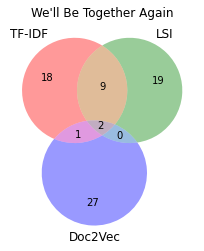

In [99]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

set_tfidf = set(tfidf_tunes)
set_lsi = set(lsi_tunes)
set_word2vec = set(word2vec_tunes)

venn3([set_tfidf, set_lsi, set_word2vec], 
      set_labels=('TF-IDF', 'LSI', 'Doc2Vec'),
      )
plt.title(f"{tune}")
plt.show()